In [1]:
# AutoML con PyCaret - Carga inicial del dataset
import pandas as pd
from pathlib import Path

# Ajusta la ruta si usas otro archivo dentro de la carpeta datos/
data_path = Path('../datos/Lifestyle_and_Health_Risk_Prediction_Synthetic_Dataset.csv')

try:
    df = pd.read_csv(data_path)
    print(f'Datos cargados desde: {data_path}')
    print('Shape:', df.shape)
    print('\nPrimeras filas:')
    print(df.head())
except Exception as e:
    print('Error al cargar los datos:', e)
    raise

Datos cargados desde: ..\datos\Lifestyle_and_Health_Risk_Prediction_Synthetic_Dataset.csv
Shape: (5000, 12)

Primeras filas:
   age  weight  height exercise  sleep sugar_intake smoking alcohol married  \
0   56      67     195      low    6.1       medium     yes     yes     yes   
1   69      76     170     high    6.9         high      no      no      no   
2   46     106     153     high    6.6          low     yes      no      no   
3   32      54     186   medium    8.5       medium      no      no      no   
4   60      98     195     high    8.0          low      no      no     yes   

      profession   bmi health_risk  
0  office_worker  17.6        high  
1        teacher  26.3        high  
2         artist  45.3        high  
3         artist  15.6         low  
4        teacher  25.8        high  


# Selección de columnas y estructura del DataFrame

En esta celda seleccionamos las columnas que usaremos como features y mostramos la estructura del DataFrame (types, resumen estadístico y valores faltantes).

In [2]:
# Selección de columnas y análisis de estructura
# Mostrar columnas originales
print('Columnas originales:')
print(df.columns.tolist())

# Información general (info) y tipos
print('\nEstructura del DataFrame (info):')
df_info = df.info()
# Mostrar descripción estadística (incluye categóricas)
print('\nDescripción estadística (transpuesta):')
print(df.describe(include='all').transpose())

# Definir features y target (ajusta si quieres excluir/añadir columnas)
selected_features = ['age','weight','height','exercise','sleep','sugar_intake','smoking','alcohol','married','profession','bmi']
target = 'health_risk'

# Verificar que las columnas existan en el DataFrame
selected_features = [c for c in selected_features if c in df.columns]
if target not in df.columns:
    raise ValueError(f'Columna objetivo {target} no encontrada en el DataFrame')

# Crear DataFrame seleccionado
df_selected = df[selected_features + [target]].copy()

# Conversión/saneamiento mínimo: sugar_intake numérico, binarias a 0/1
if 'sugar_intake' in df_selected.columns:
    df_selected['sugar_intake'] = pd.to_numeric(df_selected['sugar_intake'], errors='coerce')
for col in ['smoking','alcohol']:
    if col in df_selected.columns:
        df_selected[col] = df_selected[col].astype(str).str.strip().str.lower().map(lambda x: 1 if x == 'yes' else 0)
        df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce').fillna(0).astype(int)

# Mostrar shape y primeros registros del DataFrame seleccionado
print('\nDataFrame seleccionado - shape:', df_selected.shape)
print(df_selected.head())

# Valores faltantes por columna
print('\nValores faltantes por columna:')
print(df_selected.isna().sum())

Columnas originales:
['age', 'weight', 'height', 'exercise', 'sleep', 'sugar_intake', 'smoking', 'alcohol', 'married', 'profession', 'bmi', 'health_risk']

Estructura del DataFrame (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           5000 non-null   int64  
 1   weight        5000 non-null   int64  
 2   height        5000 non-null   int64  
 3   exercise      5000 non-null   object 
 4   sleep         5000 non-null   float64
 5   sugar_intake  5000 non-null   object 
 6   smoking       5000 non-null   object 
 7   alcohol       5000 non-null   object 
 8   married       5000 non-null   object 
 9   profession    5000 non-null   object 
 10  bmi           5000 non-null   float64
 11  health_risk   5000 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 468.9+ KB

Descripción estadística (transpuesta)

## AutoML (scikit-learn) — configuración de imputación y preprocesado


En lugar de PyCaret (no compatible con Python 3.12 en este entorno), construiremos un flujo AutoML ligero con scikit-learn que permite controlar estrategias de imputación numérica y categórica, codificación y escalado. Se compararán LogisticRegression, RandomForest y XGBoost usando CV y se guardará el mejor modelo.

Numeric cols: ['age', 'weight', 'height', 'sleep', 'sugar_intake', 'bmi']
Categorical cols: ['exercise', 'married', 'profession']
Cross-validando LogisticRegression...
Cross-validando RandomForest...
Cross-validando XGBoost...

Resultados (ordenados por f1_macro_mean):
                model  fit_time  score_time  accuracy_mean  f1_macro_mean  \
0             XGBoost  0.139747    0.018005        0.83925       0.811731   
1        RandomForest  0.746567    0.060943        0.83900       0.807743   
2  LogisticRegression  0.024977    0.014981        0.81025       0.764474   

   roc_auc_mean  time_secs  
0      0.925288   1.278102  
1      0.929506   2.039521  
2      0.884486   2.024993  

Evaluación en conjunto de prueba:
              precision    recall  f1-score   support

        high       0.89      0.87      0.88       698
         low       0.71      0.74      0.73       302

    accuracy                           0.83      1000
   macro avg       0.80      0.80      0.80      100

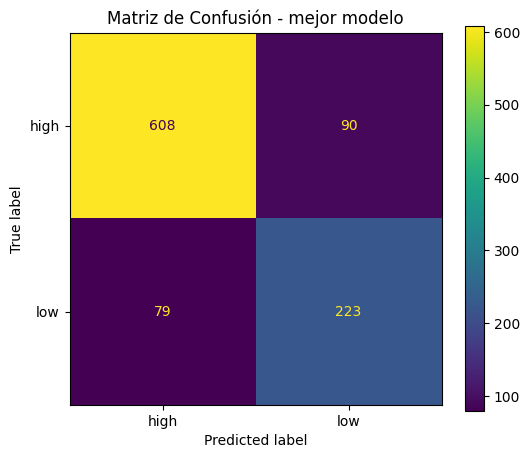

Modelo guardado en: ..\models\sk_auto_best.joblib


In [ ]:
# Configuración y ejecución AutoML con scikit-learn


# Parámetros de control: ajusta según prefieras
numeric_imputer = 'median'  # opciones: 'median','mean','constant'
categorical_imputer = 'most_frequent'  # opciones: 'most_frequent','constant'
use_scaler = True  # True para StandardScaler
encoder_type = 'onehot'  # 'onehot' o 'ordinal'
cv_folds = 5
random_state = 42


import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# X, y preparados en df_selected y target
X = df_selected.drop(target, axis=1)
y = df_selected[target].astype(str)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
# dividir
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=random_state)

# identificar columnas num/cat
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print('Numeric cols:', numeric_cols)
print('Categorical cols:', categorical_cols)

# construir transformadores
num_imputer = SimpleImputer(strategy=numeric_imputer)
num_steps = [('imputer', num_imputer)]
if use_scaler:
    num_steps.append(('scaler', StandardScaler()))
numeric_transformer = Pipeline(num_steps)

cat_imputer_strategy = 'constant' if categorical_imputer == 'constant' else 'most_frequent'
cat_imputer = SimpleImputer(strategy=cat_imputer_strategy, fill_value='missing')
if encoder_type == 'onehot':
    # OneHotEncoder parameter name differs across sklearn versions (sparse vs sparse_output). Try both.
    try:
        cat_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    except TypeError:
        cat_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    categorical_transformer = Pipeline([('imputer', cat_imputer), ('onehot', cat_encoder)])
else:
    cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    categorical_transformer = Pipeline([('imputer', cat_imputer), ('ordinal', cat_encoder)])

preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_cols), ('cat', categorical_transformer, categorical_cols)], remainder='drop')

# modelos a comparar
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=random_state),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=random_state)
}
# XGBoost si está disponible
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
except Exception as e:
    print('XGBoost no disponible:', e)

# evaluar con cross_validate
scoring = ['accuracy','f1_macro','roc_auc']
import time
results = []
for name, clf in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', clf)])
    print(f'Cross-validando {name}...')
    t0 = time.time()
    cvres = cross_validate(pipe, X_train, y_train, cv=cv_folds, scoring=scoring, return_train_score=False, n_jobs=-1)
    t1 = time.time()
    results.append({
        'model': name,
        'fit_time': np.mean(cvres['fit_time']),
        'score_time': np.mean(cvres['score_time']),
        'accuracy_mean': np.mean(cvres['test_accuracy']),
        'f1_macro_mean': np.mean(cvres['test_f1_macro']),
        'roc_auc_mean': np.mean(cvres['test_roc_auc']),
        'time_secs': t1-t0
    })
results_df = pd.DataFrame(results).sort_values('f1_macro_mean', ascending=False).reset_index(drop=True)
print('\nResultados (ordenados por f1_macro_mean):')
print(results_df)

# Entrenar el mejor modelo en todo el conjunto de entrenamiento y evaluar en test
best_name = results_df.loc[0,'model']
from copy import deepcopy
best_clf = deepcopy(models[best_name])
best_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', best_clf)])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
print('\nEvaluación en conjunto de prueba:')
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax)
plt.title('Matriz de Confusión')
plt.show()

# Guardar el modelo final y el label encoder
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)
save_path = model_dir / 'sk_auto_best.joblib'
joblib.dump({'pipeline': best_pipeline, 'label_encoder': le}, save_path)
print(f'Modelo guardado en: {save_path}')

## Afinado de hiperparámetros (RandomizedSearch) y feature importance
Vamos a ejecutar una búsqueda aleatoria limitada sobre el mejor estimador (XGBoost si está disponible, sino RandomForest). Usaremos scoring='f1_macro' y un número moderado de iteraciones para no demorar demasiado. Después guardaremos el modelo afinado y graficaremos las importancias de features con nombres legibles.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from scipy.stats import randint, uniform
import time

# Seleccionar el estimador base (XGBoost si está, sino RandomForest)
if 'XGBoost' in models:
    base_name = 'XGBoost'
    base_est = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    param_dist = {
        'clf__n_estimators': randint(50, 400),
        'clf__max_depth': randint(3, 12),
        'clf__learning_rate': uniform(0.01, 0.3),
        'clf__subsample': uniform(0.6, 0.4),
        'clf__colsample_bytree': uniform(0.5, 0.5)
    }
else:
    base_name = 'RandomForest'
    base_est = RandomForestClassifier(random_state=random_state)
    param_dist = {
        'clf__n_estimators': randint(100, 400),
        'clf__max_depth': randint(5, 30),
        'clf__min_samples_split': randint(2, 10)
    }

pipe = Pipeline([('preprocessor', preprocessor), ('clf', base_est)])
n_iter_search = 24
print(f'Iniciando RandomizedSearchCV sobre {base_name} con {n_iter_search} iteraciones...')
t0 = time.time()
rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter_search, scoring='f1_macro', cv=3, random_state=random_state, n_jobs=-1, verbose=1)
rs.fit(X_train, y_train)
t1 = time.time()
print(f'RandomizedSearchCV finalizado en {t1-t0:.1f}s')
print('Mejor score CV:', rs.best_score_)
print('Mejores parámetros:')
print(rs.best_params_)

# Evaluar en test
best_tuned = rs.best_estimator_
y_pred_tuned = best_tuned.predict(X_test)
print('\nReporte en test (modelo afinado):')
print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))

# Guardar modelo afinado
import joblib
save_path_tuned = Path('../models')/ 'sk_auto_best_tuned.joblib'
joblib.dump({'pipeline': best_tuned, 'label_encoder': le, 'cv_results': rs.cv_results_}, save_path_tuned)
print(f'Modelo afinado guardado en: {save_path_tuned}')

# Extraer nombres de features transformadas de forma robusta
def get_feature_names_from_preprocessor(preprocessor, numeric_cols, categorical_cols):
    try:
        # scikit-learn >=1.0 supports get_feature_names_out
        # Pasar la lista de features originales ayuda en algunas versiones
        return list(preprocessor.get_feature_names_out(numeric_cols + categorical_cols))
    except Exception:
        # Fallback: build names manually
        feature_names = []
        # numeric names are same
        feature_names += numeric_cols
        # categorical: check OneHotEncoder categories
        try:
            # encontrar el transformador para cat
            # preprocessor debe estar ya ajustado (fitted) para acceder a transformers_ y a categories_
            for name, trans, cols in preprocessor.transformers_:
                if name == 'cat':
                    # trans puede ser un pipeline
                    if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
                        ohe = trans.named_steps['onehot']
                        cats = ohe.categories_
                        for col, cat_list in zip(cols, cats):
                            # omitir la primera si drop='first'
                            start = 1 if getattr(ohe, 'drop', None) else 0
                            for cat in cat_list[start:]:
                                feature_names.append(f\
)
                    else:
                        # Si no hay onehot, añadir el nombre de la columna directamente
                        feature_names += list(cols)
                    break
        except Exception:
            pass
        return feature_names
# Usar el preprocessor ajustado (fitted) dentro del pipeline afinado si está disponible
if 'best_tuned' in globals() and hasattr(best_tuned, 'named_steps') and 'preprocessor' in best_tuned.named_steps:
    fitted_preprocessor = best_tuned.named_steps['preprocessor']
else:
    # fallback al preprocessor original (puede no estar ajustado en todos los casos)
    fitted_preprocessor = preprocessor
feat_names = get_feature_names_from_preprocessor(fitted_preprocessor, numeric_cols, categorical_cols)
print('\nNúmero de features transformadas:', len(feat_names))
print('Algunas features:', feat_names[:20])
# Obtener importancias si el estimador lo permite
estimator = best_tuned.named_steps['clf']
importances = None
if hasattr(estimator, 'feature_importances_'):
    importances = estimator.feature_importances_
elif hasattr(estimator, 'coef_'):
    # coef_ puede ser 2D en problemas multiclase; reducir apropiadamente
    coef = estimator.coef_
    if coef.ndim == 1:
        importances = np.abs(coef).ravel()
    else:
        importances = np.mean(np.abs(coef), axis=0).ravel()
if importances is not None and len(importances) == len(feat_names):
    fi = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(30)
    print('\nTop 10 features por importancia:')
    print(fi.head(10))
    # Gráfica (títulos en español)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(fi['feature'].iloc[::-1], fi['importance'].iloc[::-1])
    plt.title('Importancia de variables (top 30)')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()
else:
    print('No fue posible obtener importancias compatibles con nombres de features (longitud mismatch o método no disponible).')

Iniciando RandomizedSearchCV sobre XGBoost con 24 iteraciones...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
RandomizedSearchCV finalizado en 5.3s
Mejor score CV: 0.8218750016328787
Mejores parámetros:
{'clf__colsample_bytree': 0.6448757264568841, 'clf__learning_rate': 0.058366386176201324, 'clf__max_depth': 4, 'clf__n_estimators': 219, 'clf__subsample': 0.9232481518257668}

Reporte en test (modelo afinado):
              precision    recall  f1-score   support

        high       0.88      0.87      0.87       698
         low       0.70      0.72      0.71       302

    accuracy                           0.82      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.82      0.82      0.82      1000

Modelo afinado guardado en: ..\models\sk_auto_best_tuned.joblib

Número de features transformadas: 17
Algunas features: ['age', 'weight', 'height', 'sleep', 'sugar_intake', 'bmi', <_io.TextIOWrapper name='..\\requirements.txt' mode='w' encoding

In [7]:
# Guardar environment / requirements
# Generaré un `requirements.txt` con las dependencias del kernel para reproducibilidad.
# Esto guardará el resultado de `pip freeze` en el archivo `requirements.txt` en la carpeta raíz del proyecto.


import subprocess
import sys


req_file = Path('../requirements.txt')
print('Generando requirements en:', req_file)
with open(req_file, 'w', encoding='utf-8') as f:
    subprocess.check_call([sys.executable, '-m', 'pip', 'freeze'], stdout=f)
print('requirements.txt creado.')

Generando requirements en: ..\requirements.txt
requirements.txt creado.
